Tracé des courbes équipotentiels et des lignes de champ (entrer 1) ou comparaison des méthodes en temps et en consommation de mémoire (entrer 2) ou influence de la précision et nombre d'itérations (entrer 3) 3


Critère de convergence = 1e-05
Nombre d'itérations nécessaires avec la méthode de Jacobi 32
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel 42
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel adaptative 39
Critère de convergence = 1e-06
Nombre d'itérations nécessaires avec la méthode de Jacobi 312
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel 224
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel adaptative 64
Critère de convergence = 1e-07
Nombre d'itérations nécessaires avec la méthode de Jacobi 776
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel 448
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel adaptative 84
Critère de convergence = 1e-08
Nombre d'itérations nécessaires avec la méthode de Jacobi 1305
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel 674
Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel adaptative 99


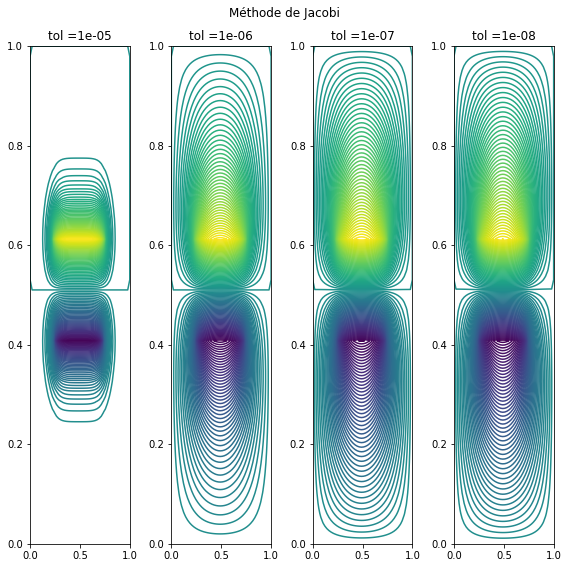

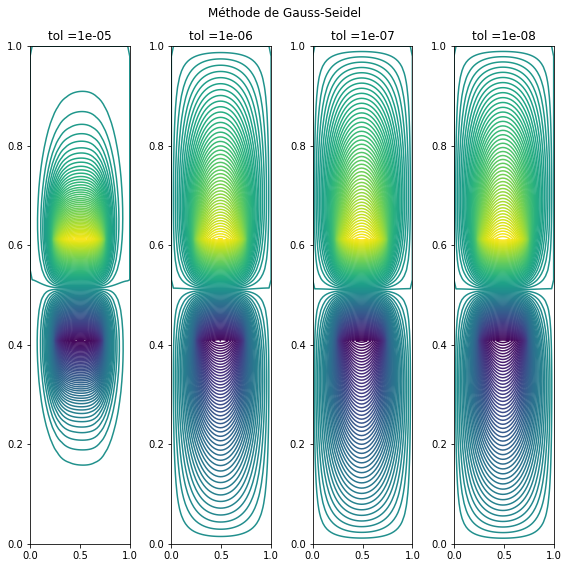

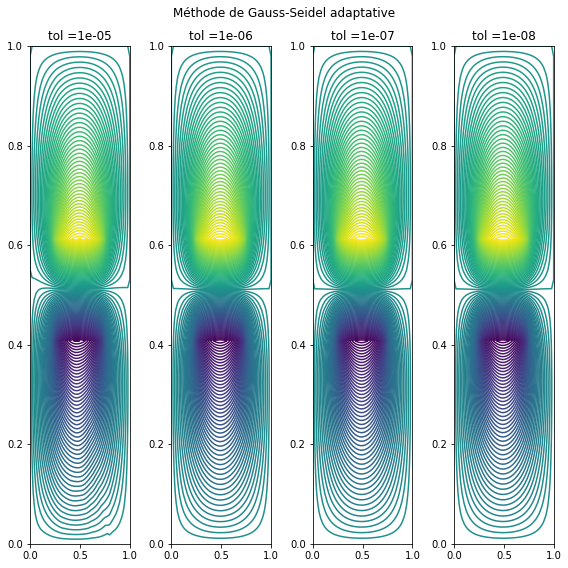

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import tracemalloc

plt.rcParams['figure.figsize'] = [8, 8] # Définition de la taille des figures pour les tracés


#------------ Implémentation des quatres méthodes de résolution de l'équation de Poisson --------------

# Méthode classique : on met le système sous la forme matricielle AF = G, puis on calcul la solution 
# F = Inv(A)G en utilisant la fonction np.linalg.solve. 

def poisson_solve_classic(nx, ny, Lx, Ly, g, CL):

    """Résolution de l'équation de Poisson à deux dimensions, avec un second membre indépendant du temps 
    et des conditions aux bords de Dirichlet par la méthode du Pivot de Gauss classique.

    Paramètres
    ----------
    nx : int
        Nombre de subdivisions du maillages dans la direction x
    ny : int
        Nombre de subdivisions du maillages dans la direction y
    Lx : float
        Longueur de l'intervalle de variation de x
    Ly : float
        Longueur de l'intervalle de variation de y
    g : array
       Fonction indépendante du temps présente dans le membre de gauche de l'équation
    CL : array 
        Conditions aux bords de Dirichlet dans l'ordre Ouest, Est, Sud, Nord

    Sortie
    -------
    u : array      
       Solution de l'équation de Poisson que l'on cherchait à résoudre       
    """  

    # Initialisation des différentes matrices
    N = (nx+1)*(ny+1) # Définition de N pour pouvoir ensuite initialiser correctement les matrices des membres de gauche et de droite
    A = np.zeros((N,N)) # Initialisation de la matrice des coefficients de taille (N,N) dans le membre de gaiche
    G = np.zeros((N,1)) # Initialisation de la matrice du second membre, vecteur colonne de longueur N

    # Calcul de la distance entre deux points successifs du maillage dans les directions x et y (pas)
    dx = Lx/nx # Il y a nx+1 points dans la direction x, on divise donc Lx par nx pour avoir le nombre de points de maillage dans cette direction
    dy = Ly/ny # Idem : ny+1 points dans la direction y, on divise donc Ly par ny pour avoir le nombre de points de maillage dans cette direction

    # Remplissage des deux matrices précédement initialisées :
    # L'idée est de transformer un tableau 2D en tableau 1D pour simplifier l'écriture du code. En effet, 
    # un tableau 2D de taille (nx,ny) peut être vu comme un tableau 1D contenant nx*ny élements. Les 
    # indices du tableau 2D peuvent être relié à l'indice unique du tableau 1D en utilisant la relation 
    # indice = i + j*nx. Ainsi l'élément au coordonnées (i,j) dans le tableau 2D se retrouve à la position 
    # "indice" dans le tableau 1D. 
    # Exemple pour une matrice de taille (2,2) : (0,0) --> 0 ; (0,1) --> 2 ; (1,0) --> 1 ; (1,1) --> 3.
    # Or, dans notre cas, la matrice A est composées de (nx+1)*(ny+1) blocs, de taille (nx+1,ny+1). On va, à 
    # l'aide du nouvelle indice, pouvoir considérer chacun de ces blocs comme un tableau 1D contenant 
    # (nx+1)*(ny+1) éléments. La matrice A va donc pouvoir être vu comme un tableau 1D contenant 
    # (nx+1)*(ny+1) élements, chacun de ces éléments étant eux même des tableaux 1D de taille (nx+1)*(ny+1)
    # élements. L'avantage de cette méthode de parcours de A est quelle n'entraine pas d'ajout de boucle 
    # supplémentaire pour remplir la matrice du second membre G : tout est faisable avec l'indexation 
    # "indice".
    
    # On s'intéresse dans un premier temps aux termes intérieurs
    for i in range(1, nx): # L'indexation selon x va de 0 à nx+1 mais ici on ne s'intéresse qu'aux points intérieurs et non pas aux termes de bords (en 0 et nx+1)
        for j in range(1, ny): # Idem que ci-dessus : seul les points intérieurs nous intéressent ici
            idx = i*(ny+1) + j # Définition de l'indice évoqué ci-dessus
            # Les trois lignes ci-dessous permettent de remplir les blocs diagonaux (ces blocs diagonaux sont des matrices tridiagonales).
            A[idx, idx] = -2.0*(1/dx**2 + 1/dy**2) # Remplissage de la grande diagonale de la matrice pour les points intérieurs
            A[idx, idx-1] = 1/dy**2 # Remplissage de la diagonale au-dessus de la grande diagonale
            A[idx, idx+1] = 1/dy**2 # Remplissage de la diagonale en-dessous de la grande diagonale
            # Les deux lignes ci-dessous permettent de remplir les blocs en dessous et au dessus des blocs diagonaux (la matrice A est une matrice tridiagonale par blocs)
            A[idx, idx-ny-1] = 1/dx**2 # Remplissage de la diagonale des blocs situés dans la diagonale en dessous des blocs diagonaux
            A[idx, idx+ny+1] = 1/dx**2 # Remplissage de la diagonale des blocs situés dans la diagonale au dessus des blocs diagonaux  
            G[idx] = g[i, j] # Remplissage de la matrice (vecteur colonne) du membre de droite (à l'exception des termes de bords)
    
    # On s'intéresse maintenant aux termes de bord
    for i in range(ny+1): # Un seul indice suffit à placer les termes de bords, puisque ces derniers sont soit sur des diagonales/sur-diagonales/sous-diagonales des blocs constituant A, soit dans le vecteur colonne G 
        A[i,i] = 1 # On place des 1 sur la diagonale du premier bloc en haut à gauche de la matrice A
        A[ny*(ny+1) + i, ny*(ny+1) + i] = 1 # On place des 1 sur le dernier bloc en bas à droite de la matrice A
        A[i*(ny+1), i*(ny+1)] = 1 # On place des 1 sur les premières cases (en haut à gauche) de chacun des blocs diagonaux de la matrice A (on commence à partir du second bloc diagonal et on s'arrête à l'avant dernier, le premier et le dernier comportant déjà des 1 sur leur diagonale, comme nous l'avons décidé aux deux lignes ci dessus : A[i,i] = 1 et A[ny*(ny+1) + i, ny*(ny+1) + i] = 1)
        A[i*(ny+1) + nx, i*(ny+1) + nx] = 1 # On place des 1 sur les dernières cases (en bas à droite) de chacun des blocs diagonaux de la matrice A (idem, on commence à partir du second bloc et on s'arrête à l'avant dernier)
        # Les quatre prochaines lignes permettent de placer les termes issus des conditions aux limites dans le membre de droite
        G[i] = CL[0] # Conditions aux limites à l'Ouest : placées dans les ny+1 premières cases du vecteur colonne constituant le membre de droite
        G[ny*(ny+1) + i] = CL[1] # Conditions aux limites à l'Est : placées dans les ny+1 dernières cases du vecteur colonne constituant le membre de droite
        G[i*(ny+1)] = CL[2] # Conditions aux limites au Sud : placées dans les premières cases des ny-1 sous vecteurs de taille ny+1 contenus dans le vecteur colonne du membre de droite (on commence par le second et on fini par l'avant dernier puisque les premiers et dernier sous vecteurs contiennent déjà respectivement les conditions aux limites à l'Ouest et à l'Est)
        G[i*(ny+1) + nx] = CL[3] # Conditions aux limites au Nord : placées dans les dernières cases des ny-1 sous vecteurs de taille ny+1 contenus dans le vecteur colonne du membre de droite (idem, on commence par le second et on fini par l'avant dernier)
    
    # Désormais, notre système est implémenté sous forme matricielle, il ne reste plus qu'à le résoudre avec np.linalg.solve (on calcul F = Inv(A)G)
    u = np.linalg.solve(A, G) # On résout le système et on obtient le vecteur solution u. np.linalg.solve renvoit un array de même taille que G, donc un vecteur colonne de longueur (nx+1*ny+1)
    return u.reshape((nx+1, ny+1)) # On va donc redimensionner le vecteur colonne u sous la forme du matrice de taille (nx+1,ny+1) et on renvoit le résultat qui constitue la solution de notre équation de Poisson à 2D, avec des conditions aux limites de Dirichlet et un second membre indépendant du temps

# Méthode de Jacobi : l'idée est d'exploiter le caractère creux (remplies essentiellement de 0) des 
# matrices obtenues lors de la résolution de l'équation de Poisson. Il s'agit d'une méthode itérative 
# de résolution d’un système d’équations linéaires. On part d’une matrice u comportant des valeurs 
# initiales nulles, puis on applique une relation de récurrence pour calculer une suite de matrices 
# La relation de récurrence doit être construite pour que la suite converge vers la solution du système
# d’équations.

def poisson_solve_jacobi(nx, ny, Lx, Ly, g, CL, max_iter=1000, tol=1e-6,it='y'):
    
    """Résolution de l'équation de Poisson à deux dimensions, avec un second membre indépendant du temps 
    et des conditions aux bords de Dirichlet par la méthode de Jacobi.

    Paramètres
    ----------
    nx : int
        Nombre de subdivisions du maillages dans la direction x
    ny : int
        Nombre de subdivisions du maillages dans la direction y
    Lx : float
        Longueur de l'intervalle de variation de x
    Ly : float
        Longueur de l'intervalle de variation de y
    g : array
       Fonction indépendante du temps présente dans le membre de gauche de l'équation
    CL : array 
        Conditions aux bords de Dirichlet dans l'ordre Ouest, Est, Sud, Nord
    max_iter : int
              Nombre maximal d'itérations que l'algorithme est autorisé à réaliser avant de devoir renvoyer une solution
    tol : float
         Critère d'arrêt de l'itération
    it : str
        Affichage ou non du nombre d'itérations effectuées ; pas défaut, 'y' pour yes --> mettre 'n' si on ne veut pas les afficher
         
    Sortie
    -------
    u : array      
       Solution de l'équation de Poisson que l'on cherchait à résoudre       
    """  
    
    # Initialisation des différentes matrices, respectivement les futurs matrices u_(k) et u_(k+1)
    u_old = np.zeros((ny, nx)) # Initialisation de la matrice u_0 à une matrice nulle
    u = np.zeros((ny, nx)) # Initialisation de la matrice u_1, qui ne contient que des 0 pour le moment
   
    # Calcul de la distance entre deux points successifs du maillage dans les directions x et y (pas)
    dx = Lx/(nx-1) # Il y a nx points dans la direction x, on divise donc Lx par (nx-1) pour avoir le nombre de points de maillage dans cette direction
    dy = Ly/(ny-1) # Idem : ny points dans la direction y, on divise donc Ly par (ny-1) pour avoir le nombre de points de maillage dans cette direction
        
    # Placement des conditions aux limites dans la matrice u_1, ces dernières ne seront plus modifiées jusqu'à la fin de l'itération, elles seront simplement copiées d'une itération à l'autre
    u[:, 0] = CL[2] # Conditions aux limites au Sud : placées dans les ny cases de la première colonne de la matrice u
    u[:, -1] = CL[3] # Conditions aux limites au Nord : placées dans les ny cases de la dernière colonne de la matrice u
    u[0, :] = CL[0] # Conditions aux limites à l'Ouest : placées dans les nx cases de la première ligne de la matrice u
    u[-1, :] = CL[1] # Conditions aux limites à l'Est : placées dans les nx cases de la dernière ligne de la matrice u
    
    # Boucles d'itérations
    for k in range(max_iter): # On définit un nombre maximale de boucle d'itérations que l'on peut effectuer avant de retourner un résultat : ce dernier n'a d'importance que si la tolérance exigée n'est pas atteinte au bout du nombre maximum d'itérations autorisé, cela évite de faire tourner le code trop longtemps
        # Pour définir la méthode (et l’implémenter), il est plus simple de garder la numérotation des inconnues à deux indices, correspondant à la grille de discrétisation, plutôt que d'utiliser l'indice 1D comme dans la méthode du Pivot de Gauss
        for i in range(1, ny-1): # Parcours des lignes de la matrice, correspondant à la coordonnée y (on parcourt entre la seconde et l'avant dernière ligne, puisque les premières et dernières sont déjà remplies par les conditions aux limites (voir ci-dessus)
            for j in range(1, nx-1): # Parcours des colonnes de la matrice, correspondant à la coordonnée x (on parcourt entre la seconde et l'avant dernière ligne, puisque les premières et dernières sont déjà remplies par les conditions aux limites (voir ci-dessus)
                u[i, j] = (1.0/(2.0*(1/dx**2 + 1/dy**2)))*((u_old[i+1, j] + u_old[i-1, j])/dx**2 + (u_old[i, j+1] + u_old[i, j-1])/dy**2 - g[i, j]) # Chacun des points intérieurs de u_(k+1) (u) sont actualisés à partir des valeurs de u_k (u_old) ; un point intérieur de u_(k+1), u[i,j], est calculé comme la somme de la moyenne des valeurs voisines en (i+1,j), (i-1,j), (i,j-1), (i,j+1) et d’une perturbation g[i,j]
        change = np.abs((u - u_old)).max() # On calcul la variation maximale des coefficients entre u_(k+1) (u) et u_k (u_old)
        u_old = u.copy() # On actualise la nouvelle matrice u_old, qui devient u_(k+1) et qui permettra de calculer u_(k+2), la futur matrice u lors de la prochaine itération
        if change < tol: # On regarde si la variation maximale des coefficients entre u_(k+1) et u_k est supérieure ou inférieure à la tolérance que l'on s'est fixé au départ : si la variation est inférieure à la tolérance, cela signifie que l'on peut supposer que la solution est a peu prêt constante et on peut donc la retourner, sinon, il faut continuer à itérer
            break # Si la variation est inférieure à la tolérance, on sort de la boucle d'itération et on retourne la solution de l'équation de Poisson
    if it == 'y':
        print("Nombre d'itérations nécessaires avec la méthode de Jacobi",k) # Affiche le nombre d'itérations nécessaire pour atteindre le critère de convergence que l'on s'est fixé : permet de savoir si l'on a pas atteint les 1000 itérations autorisées
    return u # Retourne u sous la forme du matrice de taille (nx,ny), solution de notre équation de Poisson à 2D, avec des conditions aux limites de Dirichlet et un second membre indépendant du temps

# Méthode de Gauss-Seidel : La méthode de Gauss-Seidel est une amélioration de la méthode de Jacobi, 
# consistant à modifier la matrice en ligne, c’est-à-dire sans créer une nouvelle matrice, contrairement
# à ce qui est réalisé dans le cas de la méthode de Jacobi. On conserve le principe de l’algorithme de 
# Jacobi pour lequel le tableau u des potentiels est balayé selon les indices i et j croissants. Ainsi,
# au moment de calculer u_k+1(i, j), on a déjà calculé u_k+1(i − 1, j) et u_k+1(i, j − 1), mais pas 
# encore u_k+1(i + 1, j), ni u_k+1(i, j + 1). Par conséquent, la modification de u_k+1(i,j) fait appel 
# à deux points déjà calculés au cours de la même itération : le point situé à sa gauche et le point 
# situé en dessous.

def poisson_solve_gauss_seidel(nx, ny, Lx, Ly, g, CL, max_iter=1000, tol=1e-6, it='y'):
    
    """Résolution de l'équation de Poisson à deux dimensions, avec un second membre indépendant du temps 
    et des conditions aux bords de Dirichlet par la méthode de Gauss-Seidel.

    Paramètres
    ----------
    nx : int
        Nombre de subdivisions du maillages dans la direction x
    ny : int
        Nombre de subdivisions du maillages dans la direction y
    Lx : float
        Longueur de l'intervalle de variation de x
    Ly : float
        Longueur de l'intervalle de variation de y
    g : array
       Fonction indépendante du temps présente dans le membre de gauche de l'équation
    CL : array 
        Conditions aux bords de Dirichlet dans l'ordre Ouest, Est, Sud, Nord
    max_iter : int
              Nombre maximal d'itérations que l'algorithme est autorisé à réaliser avant de devoir renvoyer une solution
    tol : float
         Critère d'arrêt de l'itération
    it : str
        Affichage ou non du nombre d'itérations effectuées ; pas défaut, 'y' pour yes --> mettre 'n' si on ne veut pas les afficher
         
    Sortie
    -------
    u : array      
       Solution de l'équation de Poisson que l'on cherchait à résoudre       
    """  
    
    # Initialisation des différentes matrices, respectivement les futurs matrices u_(k) et u_(k+1)
    u_old = np.zeros((ny, nx)) # Initialisation de la matrice u_0 à une matrice nulle
    u = np.zeros((ny, nx)) # Initialisation de la matrice u_1, qui ne contient que des 0 pour le moment
        
    # Calcul de la distance entre deux points successifs du maillage dans les directions x et y (pas)
    dx = Lx/(nx-1) # Il y a nx points dans la direction x, on divise donc Lx par (nx-1) pour avoir le nombre de points de maillage dans cette direction
    dy = Ly/(ny-1) # Idem : ny points dans la direction y, on divise donc Ly par (ny-1) pour avoir le nombre de points de maillage dans cette direction

    # Placement des conditions aux limites dans la matrice u_1, ces dernières ne seront plus modifiées jusqu'à la fin de l'itération, elles seront simplement copiées d'une itération à l'autre
    u[:, 0] = CL[2] # Conditions aux limites au Sud : placées dans les ny cases de la première colonne de la matrice u
    u[:, -1] = CL[3] # Conditions aux limites au Nord : placées dans les ny cases de la dernière colonne de la matrice u
    u[0, :] = CL[0] # Conditions aux limites à l'Ouest : placées dans les nx cases de la première ligne de la matrice u
    u[-1, :] = CL[1] # Conditions aux limites à l'Est : placées dans les nx cases de la dernière ligne de la matrice u

    # Boucles d'itérations
    for k in range(max_iter): # On définit un nombre maximale de boucle d'itérations que l'on peut effectuer avant de retourner un résultat : ce dernier n'a d'importance que si la tolérance exigée n'est pas atteinte au bout du nombre maximum d'itérations autorisé, cela évite de faire tourner le code trop longtemps
        # Pour définir la méthode (et l’implémenter), il est plus simple de garder la numérotation des inconnues à deux indices, correspondant à la grille de discrétisation, plutôt que d'utiliser l'indice 1D comme dans la méthode du Pivot de Gauss
        for i in range(1, ny-1): # Parcours des lignes de la matrice, correspondant à la coordonnée y (on parcourt entre la seconde et l'avant dernière ligne, puisque les premières et dernières sont déjà remplies par les conditions aux limites (voir ci-dessus)
            for j in range(1, nx-1): # Parcours des colonnes de la matrice, correspondant à la coordonnée x (on parcourt entre la seconde et l'avant dernière ligne, puisque les premières et dernières sont déjà remplies par les conditions aux limites (voir ci-dessus)
                u[i, j] = (1.0/(2.0*(1/dx**2 + 1/dy**2)))*((u[i+1, j] + u[i-1, j])/dx**2 + (u[i, j+1] + u[i, j-1])/dy**2 - g[i, j]) # Le schéma itératif utilisé est le même que dans la méthode de Jacobi, sauf que cette fois une seul matrice est utilisée. En effet, on utilise les points u_k+1(i-1,j) et u_k+1(i,j-1) déjà calculés lors de l'itération actuelle, et les points u_k(i+1,j) et u_k(i,j+1) calculés lors de l'itération précédente. Tous ces points sont contenus dans la matrice u, qui se suffit donc à elle-même 
        change = np.abs((u - u_old)).max() # On regarde si la variation maximale des coefficients entre u_(k+1) et u_k est supérieure ou inférieure à la tolérance que l'on s'est fixé au départ : si la variation est inférieure à la tolérance, cela signifie que l'on peut supposer que la solution est a peu prêt constante et on peut donc la retourner, sinon, il faut continuer à itérer
        u_old = u.copy() # Malheureusement, nous avons quand même besoin de réaliser le test d'arrêt qui consiste à comparer les matrices u_k et u_(k+1), il faut donc malgré tout conserver une copie du tableau précédent pour calculer l’écart entre le nouveau tableau et l’ancien tableau : cette copie est réalisée UNIQUEMENT pour effectuer le test d'arrêt
        if change < tol: # Si la variation est inférieure à la tolérance, on sort de la boucle d'itération et on retourne la solution de l'équation de Poisson
            break # Sortie de la boucle d'itérations
    if it == 'y':
        print("Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel",k) # Affiche le nombre d'itérations nécessaire pour atteindre le critère de convergence que l'on s'est fixé : permet de savoir si l'on a pas atteint les 1000 itérations autorisées
    return u # Retourne u sous la forme du matrice de taille (nx,ny), solution de notre équation de Poisson à 2D, avec des conditions aux limites de Dirichlet et un second membre indépendant du temps

# Méthode de sur-relaxation ou méthode de Gauss–Seidel adaptative : les schémas de Jacobi et de 
# Gauss-Seidel expriment u_k+1(i, j) en fonction des valeurs de u_k autour du point (i, j) mais pas de 
# la valeur u_k(i, j). La méthode de sur-relaxation (Successive Over Relaxation method) consiste à 
# exprimer u_k+1(i,j) comme une combinaison convexe de u_k(i, j) et de la valeur donnée par le schéma 
# de Gauss-Seidel. Le problème est en effet que méthode de Gauss-Seidel converge très lentement, le 
# nombre d’itérations nécessaire pour obtenir une bonne approximation est proportionnel au nombre de 
# points du maillage. La méthode de sur-relaxation permet d’accélérer considérablement la convergence.
# Dans cette méthode, on introduit le paramètre de relaxation w (voir expression dans rapport). 
# Si 0 < w < 1, la nouvelle valeur de u_k+1(i,j) est une moyenne pondérée de l’ancienne (u_k(i,j)) et de 
# celle donnée par le schéma de Gauss-Seidel. Dans ce cas, la convergence est ralentie (sous-relaxation). 
# La sur-relaxation consiste à choisir une valeur de w strictement supérieure à 1, pour que la méthode 
# converge, il faut que 1 < w < 2. Il existe une valeur optimale du paramètre de relaxation, qui permet
# d’obtenir une convergence beaucoup plus rapide que la méthode de Gauss-Seidel, avec un nombre 
# d’itérations bien plus faible. Cette valeur optimale dépend de l’équation discrétisée, des conditions
# limites, et de la taille du maillage. Pour l’équation de Poisson avec des conditions limites de
# Dirichlet sur les bords, l’expression du paramètre optimal est connue et va être utilisée dans le code
# qui suit.

def poisson_solve_gauss_seidel_adapt(nx, ny, Lx, Ly, g, CL, omega='c', max_iter=1000, tol=1e-6, it='y'):
           
    """Résolution de l'équation de Poisson à deux dimensions, avec un second membre indépendant du temps 
    et des conditions aux bords de Dirichlet par la méthode de Gauss-Seidel adaptative.

    Paramètres
    ----------
    nx : int
        Nombre de subdivisions du maillages dans la direction x
    ny : int
        Nombre de subdivisions du maillages dans la direction y
    Lx : float
        Longueur de l'intervalle de variation de x
    Ly : float
        Longueur de l'intervalle de variation de y
    g : array
       Fonction indépendante du temps présente dans le membre de gauche de l'équation
    CL : array 
        Conditions aux bords de Dirichlet dans l'ordre Ouest, Est, Sud, Nord
    omega : float ou str, par défaut omega = 'c', ce qui laisse l'algorithme le choix de la valeur optimale
           Paramètre de relaxation
    max_iter : int
              Nombre maximal d'itérations que l'algorithme est autorisé à réaliser avant de devoir renvoyer une solution
    tol : float
         Critère d'arrêt de l'itération
    it : str
        Affichage ou non du nombre d'itérations effectuées ; pas défaut, 'y' pour yes --> ne rien mettre si on veut les afficher, mettre 'n' si on ne veut pas les afficher
         
    Sortie
    -------
    u : array      
       Solution de l'équation de Poisson que l'on cherchait à résoudre       
    """  

    # Initialisation des différentes matrices, respectivement les futurs matrices u_(k) et u_(k+1)
    u_old = np.zeros((ny, nx)) # Initialisation de la matrice u_0 à une matrice nulle
    u = np.zeros((ny, nx)) # Initialisation de la matrice u_1, qui ne contient que des 0 pour le moment
        
    # Calcul de la distance entre deux points successifs du maillage dans les directions x et y (pas)
    dx = Lx/(nx-1) # Il y a nx points dans la direction x, on divise donc Lx par (nx-1) pour avoir le nombre de points de maillage dans cette direction
    dy = Ly/(ny-1) # Idem : ny points dans la direction y, on divise donc Ly par (ny-1) pour avoir le nombre de points de maillage dans cette direction

    # Placement des conditions aux limites dans la matrice u_1, ces dernières ne seront plus modifiées jusqu'à la fin de l'itération, elles seront simplement copiées d'une itération à l'autre
    u[:, 0] = CL[2] # Conditions aux limites au Sud : placées dans les ny cases de la première colonne de la matrice u
    u[:, -1] = CL[3] # Conditions aux limites au Nord : placées dans les ny cases de la dernière colonne de la matrice u
    u[0, :] = CL[0] # Conditions aux limites à l'Ouest : placées dans les nx cases de la première ligne de la matrice u
    u[-1, :] = CL[1] # Conditions aux limites à l'Est : placées dans les nx cases de la dernière ligne de la matrice u

    # Choix du paramètre de relaxation
    if omega == 'c': # Si on laisse le choix ('c' pour choose, par défaut) à l'algorithme, alors on choisit la valeur optimale du paramètre de relaxation pour l’équation de Poisson avec des conditions limites de Dirichlet sur les bords dont l'expression est connue
        omega = 2/(1+np.sin(np.pi/nx)) # Choix optimal, sinon, l'utilisateur peut directement fixer la valeur de w

    # Boucles d'itérations
    for k in range(max_iter): # On définit un nombre maximale de boucle d'itérations que l'on peut effectuer avant de retourner un résultat : ce dernier n'a d'importance que si la tolérance exigée n'est pas atteinte au bout du nombre maximum d'itérations autorisé, cela évite de faire tourner le code trop longtemps
        # Pour définir la méthode (et l’implémenter), il est plus simple de garder la numérotation des inconnues à deux indices, correspondant à la grille de discrétisation, plutôt que d'utiliser l'indice 1D comme dans la méthode du Pivot de Gauss
        for i in range(1, nx-1): # Parcours des lignes de la matrice, correspondant à la coordonnée y (on parcourt entre la seconde et l'avant dernière ligne, puisque les premières et dernières sont déjà remplies par les conditions aux limites (voir ci-dessus)
            for j in range(1, ny-1): # Parcours des colonnes de la matrice, correspondant à la coordonnée x (on parcourt entre la seconde et l'avant dernière ligne, puisque les premières et dernières sont déjà remplies par les conditions aux limites (voir ci-dessus)
                u[i, j] = (1-omega)*u[i, j] + omega*(1.0/(2.0*(1/dx**2 + 1/dy**2)))*((u[i+1, j] + u[i-1, j])/dx**2 + (u[i, j+1] + u[i, j-1])/dy**2 - g[i, j]) # La méthode de sur-relaxation (Successive Over Relaxation method) consiste à exprimer u_k+1(i,j) comme une combinaison convexe de u_k(i, j) et de la valeur donnée par le schéma de Gauss-Seidel, la pondération entre chacun de ces deux termes se faisant par l'intermédiaire du paramètre de relaxation omega  
        change = np.abs((u - u_old)).max() # On regarde si la variation maximale des coefficients entre u_(k+1) et u_k est supérieure ou inférieure à la tolérance que l'on s'est fixé au départ : si la variation est inférieure à la tolérance, cela signifie que l'on peut supposer que la solution est a peu prêt constante et on peut donc la retourner, sinon, il faut continuer à itérer
        u_old = u.copy() # Malheureusement, comme pour la méthode de Gauss-Seidel, nous avons quand même besoin de réaliser le test d'arrêt qui consiste à comparer les matrices u_k et u_(k+1), il faut donc malgré tout conserver une copie du tableau précédent pour calculer l’écart entre le nouveau tableau et l’ancien tableau : cette copie est réalisée UNIQUEMENT pour effectuer le test d'arrêt
        if change < tol: # Si la variation est inférieure à la tolérance, on sort de la boucle d'itération et on retourne la solution de l'équation de Poisson
            break # Sortie de la boucle d'itérations 
    if it == 'y':
        print("Nombre d'itérations nécessaires avec la méthode de Gauss-Seidel adaptative",k) # Affiche le nombre d'itérations nécessaire pour atteindre le critère de convergence que l'on s'est fixé : permet de savoir si l'on a pas atteint les 1000 itérations autorisées
    return u # Retourne u sous la forme du matrice de taille (nx,ny), solution de notre équation de Poisson à 2D, avec des conditions aux limites de Dirichlet et un second membre indépendant du temps    

#------------------------- Application et comparaison des différentes méthodes -------------------------

# Initialisation des différents paramètres valable pour les parties application ET comparaison

Lx = 1 # Longueur de l'intervalle suivant l'axe x
Ly = 1 # Longeur de l'intervale suivant l'axe y
CL = np.array([0,0,0,0]) # Définition des conditions aux limites dans l'ordre Ouest, Est, Sud, Nord

# Définition des listes de x et y pour le tracer des surfaces/équipotentiels et le calcul des fonctions dans le second membre
# Pour la méthode classique
X_classic = np.linspace(0,Lx,nx+1) # Définition de la liste des x pour la méthode par Pivot de Gauss (fait intervenir nx+1 subdivisions contre nx pour les autres méthodes, il faut donc créer une liste spécialement pour cette méthode)
Y_classic = np.linspace(0,Ly,ny+1) # Définition de la liste des y pour la méthode par Pivot de Gauss (fait intervenir ny+1 subdivisions contre ny pour les autres méthodes, il faut donc créer une liste spécialement pour cette méthode)
X_classic,Y_classic = np.meshgrid(X_classic,Y_classic) # Transformation des vecteurs colonne de longeurs respectives nx+1 et ny+1 en matrices de taille (nx+1,ny+1)
# Pour les trois autres méthodes
X = np.linspace(0,Lx,nx) # Définition de la liste des x pour les méthodes de Jacobi, de Gauss-Seidel et de Gauss-Seidel adaptative
Y = np.linspace(0,Ly,ny) # Définition de la liste des y pour les méthodes de Jacobi, de Gauss-Seidel et de Gauss-Seidel adaptative
X,Y = np.meshgrid(X,Y) # Transformation des vecteurs colonne de longeurs respectives nx et ny en matrices de taille (nx,ny)

# Définition du membre de droite pour le cas d'un condensateur plan
def function4(a,b): # a et b sont les dimensions de la matrice du membre de droite (normalement, (Mx,My))
    mat = np.zeros((a,b)) # on initialise la matrice à 0
    mat[int(0.4*a),int(a/4):int(3*a/4)] = 1 # On place des 1 en y = 0.4 u.a., entre x = 0.25 et 0.75 u.a. (dimension horizontale de l'armature du condensateur)
    mat[int(0.6*a),int(a/4):int(3*a/4)] = -1 # On place des -1 en y = 0.4 u.a., entre x = 0.25 et 0.75 u.a. (dimension horizontale de l'armature du condensateur)
    return(mat)

# Choix des calculs que l'utilisateur souhaite mener 
choix = input("Tracé des courbes équipotentiels et des lignes de champ (entrer 1) ou comparaison des méthodes en temps et en consommation de mémoire (entrer 2) ou influence de la précision et nombre d'itérations (entrer 3)")
choix = int(choix) # On transforme la chaine de caractère choix en entier 

#------------------- Application des différentes méthodes au cas du condensateur plan ------------------

# Définition du maillage, valable uniquement pour la partie application (maillage variable dans la partie comparaison)
nx = 65 # Nombre de subdivisions du maillage suivant l'axe x
ny = 65 # Nombre de subdivisions du maillage suivant l'axe y

# Définition de la fonction dans le second membre de l'équation de Poisson, indépendante du temps
g_classic = function4(nx+1,ny+1) # Définition du second membre pour la méthode du Pivot de Gauss (les listes de X et Y contiennent un terme de plus chacune que pour les trois autres méthodes)
g = function4(nx,ny) # Définition du second membre pour les méthodes de Jacobi, de Gauss-Seidel et de Gauss-Seidel adaptative

# Tracé de courbes équipotentiel et des lignes de champ
if choix == 1 :
    # Calcul des équipotentiels et des lignes de champ
    classic = poisson_solve_classic(nx, ny, Lx, Ly, g_classic,CL) # Calcul des matrices de potentiels par la méthode classique
    Ey_classic, Ex_classic = np.gradient(-classic) # Calcul des valeurs du champ électrique
    
    jacobi = poisson_solve_jacobi(nx, ny, Lx, Ly, g, CL) # Calcul des matrices de potentiels par la méthode de Jacobi
    Ey_jacobi, Ex_jacobi = np.gradient(-jacobi) # Calcul des valeurs du champ électrique

    gauss_seidel = poisson_solve_gauss_seidel(nx, ny, Lx, Ly, g, CL) # Calcul des matrices de potentiels par la méthode de Gauss-Seidel
    Ey_gauss_seidel, Ex_gauss_seidel = np.gradient(-gauss_seidel) # Calcul des valeurs du champ électrique

    gauss_seidel_adapt = poisson_solve_gauss_seidel_adapt(nx, ny, Lx, Ly, g, CL) # Calcul des matrices de potentiels par la méthode de Gauss-Seidel adaptée
    Ey_gauss_seidel_adapt, Ex_gauss_seidel_adapt = np.gradient(-gauss_seidel_adapt) # Calcul des valeurs du champ électrique

    # Tracé des équipotentiels et des lignes de champ
    fig,ax = plt.subplots(2,2)
    ax[0,0].contour(X_classic,Y_classic,classic,100)
    ax[0,0].streamplot(X_classic,Y_classic,Ex_classic,Ey_classic)
    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('y')
    ax[0,0].set_title('Méthode classique')

    ax[0,1].contour(X,Y,jacobi,100)
    ax[0,1].streamplot(X,Y,Ex_jacobi,Ey_jacobi)
    ax[0,1].set_xlabel('x')
    ax[0,1].set_ylabel('y')
    ax[0,1].set_title('Méthode de Jacobi')

    ax[1,0].contour(X,Y,gauss_seidel,100)
    ax[1,0].streamplot(X,Y,Ex_gauss_seidel,Ey_gauss_seidel)
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('y')
    ax[1,0].set_title('Méthode de Gauss-Seidel')

    ax[1,1].contour(X,Y,gauss_seidel_adapt,100)
    ax[1,1].streamplot(X,Y,Ex_gauss_seidel_adapt,Ey_gauss_seidel_adapt)
    ax[1,1].set_xlabel('x')
    ax[1,1].set_ylabel('y')
    ax[1,1].set_title('Méthode de Gauss-Seidel adaptative')

    fig.suptitle('Les quatre méthodes pour N = 65 et tracé des lignes de champ')
    fig.tight_layout()

#---------------------------------- Comparaison des différentes méthodes ------------------------------- 

# ----- Comparaison en terme de durée et de place en mémoire en fonction de la taille du maillage -----

elif choix == 2:  
    
    #Initialisation de la liste de dimension du maillage
    nmax = 120 # valeur maximale pour la taille du maillage (voir liste à la ligne suivante)
    N = [n for n in range(2,nmax)]
    # Initialisation des listes de temps et de mémoires
    Temps_classic = []
    Mem_classic = []
    Temps_Jacobi = []
    Mem_Jacobi = []
    Temps_Gauss_Seidel = []
    Mem_Gauss_Seidel = []
    Temps_Gauss_Seidel_adapt = []
    Mem_Gauss_Seidel_adapt = []
    
    for n in N :
        print("Taille du maillage", n) 
        tracemalloc.start() # Démarrage de la mesure de la mémoire
        start_classic = time.time() # Démarrage du chronomètre
        classic = poisson_solve_classic(n, n, Lx, Ly, function4(n+1,n+1),CL) # Calcul des matrices de potentiels
        current1,peak1 = tracemalloc.get_traced_memory() # On récupère dans "current" la consommation de mémoire en temps normal, sans que l'algorithme ne tourne, et dans "peak" la consommation de mémoire maximale lorsque l'algorithme tourne 
        end_classic = time.time() # Fin du chronomètre
        tracemalloc.stop() # Fin de la mesure de mémoire
        Temps_classic.append(abs(start_classic-end_classic)) # On stock le temps d'exécution dans la liste associée à la méthode
        Mem_classic.append(abs(peak1-current1)) # On stock la mémoire utilisée dans la liste associée à la méthode
        
        tracemalloc.start() # Démarrage de la mesure de la mémoire
        start_jacobi = time.time() # Démarrage de la mesure de la mémoire
        jacobi = poisson_solve_jacobi(n, n, Lx, Ly, function4(n,n), CL,it='n') # Calcul des matrices de potentiels
        current2,peak2 = tracemalloc.get_traced_memory() # On récupère dans "current" la consommation de mémoire en temps normal, sans que l'algorithme ne tourne, et dans "peak" la consommation de mémoire maximale lorsque l'algorithme tourne 
        end_jacobi = time.time() # Fin du chronomètre
        tracemalloc.stop() # Fin de la mesure de mémoire
        Temps_Jacobi.append(abs(start_jacobi-end_jacobi)) # On stock le temps d'exécution dans la liste associée à la méthode
        Mem_Jacobi.append(abs(peak2-current2)) # On stock la mémoire utilisée dans la liste associée à la méthode
        
        tracemalloc.start() # Démarrage de la mesure de la mémoire
        start_gauss_seidel = time.time() # Démarrage de la mesure de la mémoire
        gauss_seidel = poisson_solve_gauss_seidel(n, n, Lx, Ly, function4(n,n), CL,it='n') # Calcul des matrices de potentiels
        current3,peak3 = tracemalloc.get_traced_memory() # On récupère dans "current" la consommation de mémoire en temps normal, sans que l'algorithme ne tourne, et dans "peak" la consommation de mémoire maximale lorsque l'algorithme tourne 
        end_gauss_seidel = time.time() # Fin du chronomètre
        tracemalloc.stop() # Fin de la mesure de mémoire
        Temps_Gauss_Seidel.append(abs(start_gauss_seidel-end_gauss_seidel)) # On stock le temps d'exécution dans la liste associée à la méthode
        Mem_Gauss_Seidel.append(abs(peak3-current3)) # On stock la mémoire utilisée dans la liste associée à la méthode
    
        tracemalloc.start() # Démarrage de la mesure de la mémoire
        start_gauss_seidel_adapt = time.time() # Démarrage de la mesure de la mémoire
        gauss_seidel_adapt = poisson_solve_gauss_seidel_adapt(n, n, Lx, Ly, function4(n,n), CL,it='n') # Calcul des matrices de potentiels
        current4,peak4 = tracemalloc.get_traced_memory() # On récupère dans "current" la consommation de mémoire en temps normal, sans que l'algorithme ne tourne, et dans "peak" la consommation de mémoire maximale lorsque l'algorithme tourne 
        end_gauss_seidel_adapt = time.time() # Fin du chronomètre
        tracemalloc.stop() # Fin de la mesure de mémoire
        Temps_Gauss_Seidel_adapt.append(abs(start_gauss_seidel_adapt-end_gauss_seidel_adapt)) # On stock le temps d'exécution dans la liste associée à la méthode
        Mem_Gauss_Seidel_adapt.append(abs(peak4-current4)) # On stock la mémoire utilisée dans la liste associée à la méthode
    
    # Tracé de l'évolution du temps d'exécution en fonction de la taille du maillage
    plt.figure()
    plt.plot(N,Temps_classic)
    plt.plot(N,Temps_Jacobi)
    plt.plot(N,Temps_Gauss_Seidel)
    plt.plot(N,Temps_Gauss_Seidel_adapt)
    plt.xlabel("Racine du nombre de points sur le maillage")
    plt.ylabel("Durée d'exécution de la méthode (en s)")
    plt.title("Évolution de la durée d'exécution du code en fonction du nombre de point sur le maillage")
    plt.grid()
    plt.legend(["Méthode classique","Méthode de Jacobi", "Méthode de Gauss-Seidel", "Méthode de Gauss-Seidel adaptative"])
    
    # Régression linéaire pour le cas de la méthode de Gauss-Seidel
    plt.figure()
    # On passe en échelle log afin de pouvoir récupérer le degré du polynôme par le biais du coefficient directeur du fit linéaire
    log_N = np.log(N) 
    log_gsa = np.log(Temps_Gauss_Seidel_adapt)
    coeff = np.polyfit(log_N,log_gsa,1) # Régression linéaire de la représentation logrithmique
    X = np.linspace(np.log(2),np.log(120),1000)
    Y = coeff[0]*X+coeff[1]
    plt.plot(log_N, log_gsa,'bo')
    plt.plot(X,Y,'r')
    plt.xlabel('log(N)')
    plt.ylabel("log(Temps d'exécution)")
    plt.title("Temps d'exécution de la méthode de Gauss-Seidel adaptée \n en fonction du maillage en échelle log")
    plt.grid()
    plt.legend(["Points issus de l'algorithme","Fit linéaire"])
    print("Coefficient directeur du fit linéaire", coeff[0], "Ordonnée à l'origine du fit linéaire", coeff[1]) # Affichage des coefficients du fit linéaire

    # Tracé de l'évolution de la mémoire occupée en fonction de la taille du maillage
    plt.figure()
    plt.plot(N,Mem_classic)
    plt.plot(N,Mem_Jacobi)
    plt.plot(N,Mem_Gauss_Seidel)
    plt.plot(N,Mem_Gauss_Seidel_adapt)
    plt.xlabel("Racine du nombre de points sur le maillage")
    plt.ylabel("Mémoire utilisée par la méthode (en u.a.)")
    plt.title("Évolution de la mémoire utilisée en fonction du nombre de point sur le maillage")
    plt.grid()
    plt.legend(["Méthode classique","Méthode de Jacobi", "Méthode de Gauss-Seidel", "Méthode de Gauss-Seidel adaptative"])
    
# Comparaison des trois méthodes itératives en terme de précision et de nombre d'itérations nécessaires

elif choix == 3:
    
    crit_conv = [10**(-5),10**(-6),10**(-7),10**(-8)] # Liste des critères de convergence que l'on va tester
    N = 50 # Dimension du maillage
    i = 0 # Drapeau que l'on va utiliser dans la boucle pour placer les courbes sur les différentes subplots
    X = np.linspace(0,Lx,N) # Définition de la liste des x pour les méthodes de Jacobi, de Gauss-Seidel et de Gauss-Seidel adaptative
    Y = np.linspace(0,Ly,N) # Définition de la liste des y pour les méthodes de Jacobi, de Gauss-Seidel et de Gauss-Seidel adaptative
    X,Y = np.meshgrid(X,Y) # Transformation des vecteurs colonne de longeurs respectives nx et ny en matrices de taille (nx,ny)
    # Initialisation des trois subplots
    fig1,ax1 = plt.subplots(1,4)
    fig2,ax2 = plt.subplots(1,4)
    fig3,ax3 = plt.subplots(1,4)
    for tol in crit_conv:
        print('Critère de convergence =',crit_conv[i]) # On affiche le critère de convergence utilisé pour faire le calcul
        # Remarque : on débride ici le nombre maximal d'itérations que l'on peut réaliser en le plaçant à 10000, afin de ne pas être limité dans la comparaison
        jacobi = poisson_solve_jacobi(N, N, Lx, Ly, function4(N,N), CL, max_iter = 10000, tol=tol) # Calcul des matrices de potentiels avec la méthode de Jacobi
        ax1[i].contour(X,Y,jacobi,100) # Tracé des lignes équipotentiel
        ax1[i].set_title('tol =' + str(crit_conv[i]))
        gauss_seidel = poisson_solve_gauss_seidel(N, N, Lx, Ly, function4(N,N), CL, max_iter = 10000, tol=tol) # Calcul des matrices de potentiels avec la méthode de Gauss-Seidel
        ax2[i].contour(X,Y,gauss_seidel,100) # Tracé des lignes équipotentiel
        ax2[i].set_title('tol =' + str(crit_conv[i]))
        gauss_seidel_adapt = poisson_solve_gauss_seidel_adapt(N, N, Lx, Ly, function4(N,N), CL, max_iter = 10000, tol=tol) # Calcul des matrices de potentiels avec la méthode de Gauss-Seidel adaptative
        ax3[i].contour(X,Y,gauss_seidel_adapt,100) # Tracé des lignes équipotentiel
        ax3[i].set_title('tol =' + str(crit_conv[i]))
        i+=1
    fig1.suptitle('Méthode de Jacobi')
    fig2.suptitle('Méthode de Gauss-Seidel')
    fig3.suptitle('Méthode de Gauss-Seidel adaptative')
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()